# Code for plotting figures in the paper

## Utility

In [ ]:
%env JAX_PLATFORMS=cpu

env: JAX_PLATFORMS=cpu


In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from acplot import acplot
from uncertainties import ufloat

In [ ]:
DATA_PATH = Path(os.environ.get("JPY_SESSION_NAME")).parent / "data"
ED_COLOR = "0.5"
acplot.save_dir = DATA_PATH.parent / "img"
acplot.rcParams = {"savefig.transparent": False}

In [ ]:
def correct_energy(kinetic, potential, N, Q, R, nu, q=0, kappa=1):
    # Remove background contribution
    potential -= kappa * (N**2 - q**2) / 2 / R
    # Density correction for potential energy
    if nu is not None:
        energy_in_au = (
            (kinetic - N / 2 * Q / R**2 + potential) * np.sqrt(2 * Q * nu / N) / N
        )
    else:
        energy_in_au = (kinetic + potential) / N
    # Normalize potential in the unit of 1/ell
    energy_in_ell = energy_in_au * R / np.sqrt(Q) / kappa
    return energy_in_ell

In [ ]:
def ed_energy(ed_output, N, Q, R, nu, q=0):
    return correct_energy(N / 2, ed_output / 2, N, Q, R, nu, q)

In [ ]:
llm_df = pd.read_csv(DATA_PATH / "llm_1_3.csv")
energy_vs_n_df = pd.read_csv(DATA_PATH / "energy_vs_n.csv")

In [ ]:
for _, row in energy_vs_n_df.iterrows():
    print(
        "{:g}".format(row["n"]),
        "${:.1uS}$".format(ufloat(row["energy"], row["std"])),
        "${:.6f}$".format(row["ed"]),
        sep=" & ",
        end=" \\\\\n",
    )

6 & $-0.411688(3)$ & $-0.410950$ \\
7 & $-0.411547(3)$ & $-0.410819$ \\
8 & $-0.411444(3)$ & $-0.410736$ \\
9 & $-0.411369(3)$ & $-0.410679$ \\
10 & $-0.411280(3)$ & $-0.410629$ \\
11 & $-0.411202(4)$ & $-0.410583$ \\
12 & $-0.411124(4)$ & $nan$ \\


In [ ]:
for _, row in llm_df.iterrows():
    print(
        "${:g}$".format(row["kappa"]),
        "${:.1uS}$".format(ufloat(row["overlap"], row["overlap_std"])),
        "${:.1uS}$".format(ufloat(row["n_LLL"], row["n_LLL_std"])),
        "${:.1uS}$".format(ufloat(row["energy"], row["energy_std"])),
        "${:.1uS}$".format(ufloat(row["qp_energy"], row["qp_energy_std"])),
        "${:.1uS}$".format(ufloat(row["qh_energy"], row["qh_energy_std"])),
        "${:.1uS}$".format(ufloat(row["gap"], row["gap_std"])),
        sep=" & ",
        end=" \\\\\n",
    )

$0.5$ & $0.9976(2)$ & $5.9989(8)$ & $-0.41106(2)$ & $-0.397425(8)$ & $-0.405843(7)$ & $0.1130(3)$ \\
$1$ & $0.994(2)$ & $5.9955(8)$ & $-0.411645(3)$ & $-0.39897(1)$ & $-0.406667(3)$ & $0.1058(2)$ \\
$3$ & $0.975(2)$ & $5.9644(8)$ & $-0.413331(3)$ & $-0.403202(1)$ & $-0.408784(1)$ & $0.08805(5)$ \\
$10$ & $0.873(1)$ & $5.7500(8)$ & $-0.417425(1)$ & $-0.4105431(4)$ & $-0.4136791(4)$ & $0.06377(1)$ \\


## Figure 2

In [ ]:
def train_curve_1_3(ax):
    df = pd.read_csv(DATA_PATH / "n8l21/k1/train_stats.csv")
    energy = correct_energy(
        df["kinetic"], df["potential"], 8, 21 / 2, np.sqrt(21 / 2), 1 / 3
    )
    energy = energy[energy.abs() < 10 * energy.abs().median()]
    total_steps = len(energy)
    ed = ed_energy(12.725298638045, 8, 21 / 2, np.sqrt(21 / 2), 1 / 3)

    ax.plot(energy.rolling(100).mean(), zorder=2, label="Network")
    axin = ax.inset_axes(
        [0.5, 0.2, 0.47, 0.47],
        xlim=(total_steps - 10000, total_steps),
        ylim=(-0.4116, -0.4106),
        xticklabels=[],
    )

    axin.plot(energy.rolling(100).mean(), zorder=2)
    ax.axhline(ed, color=ED_COLOR, ls="--", label="ED")
    axin.axhline(ed, color=ED_COLOR, ls="--")
    ax.set_ylim(None, -0.375)
    ax.set_ylabel(r"$E_c/N\hbar\omega_c\kappa$")
    ax.set_xlabel("Training step")
    ax.indicate_inset_zoom(axin, edgecolor="black")
    ax.legend()

In [ ]:
def train_curve_2_5(ax):
    df = pd.read_csv(DATA_PATH / "n8l16/k1/train_stats.csv")
    energy = correct_energy(df["kinetic"], df["potential"], 8, 8, np.sqrt(8), 2 / 5)
    energy = energy[energy.abs() < 10 * energy.abs().median()]
    ed = ed_energy(14.94351936216, 8, 8, np.sqrt(8), 2 / 5)

    ax.plot(energy.rolling(100).mean(), zorder=2, label="Network")
    ax.axhline(ed, color=ED_COLOR, ls="--", label="ED")
    ax.set_xlabel("Training step")
    ax.legend()

In [ ]:
def energy_vs_n(ax):
    ax.plot(energy_vs_n_df["n"], energy_vs_n_df["energy"], marker="s", label="Network")
    ax.plot(energy_vs_n_df["n"], energy_vs_n_df["ed"], marker="o", label="ED")
    ax.set_xlabel(r"$N$")
    ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


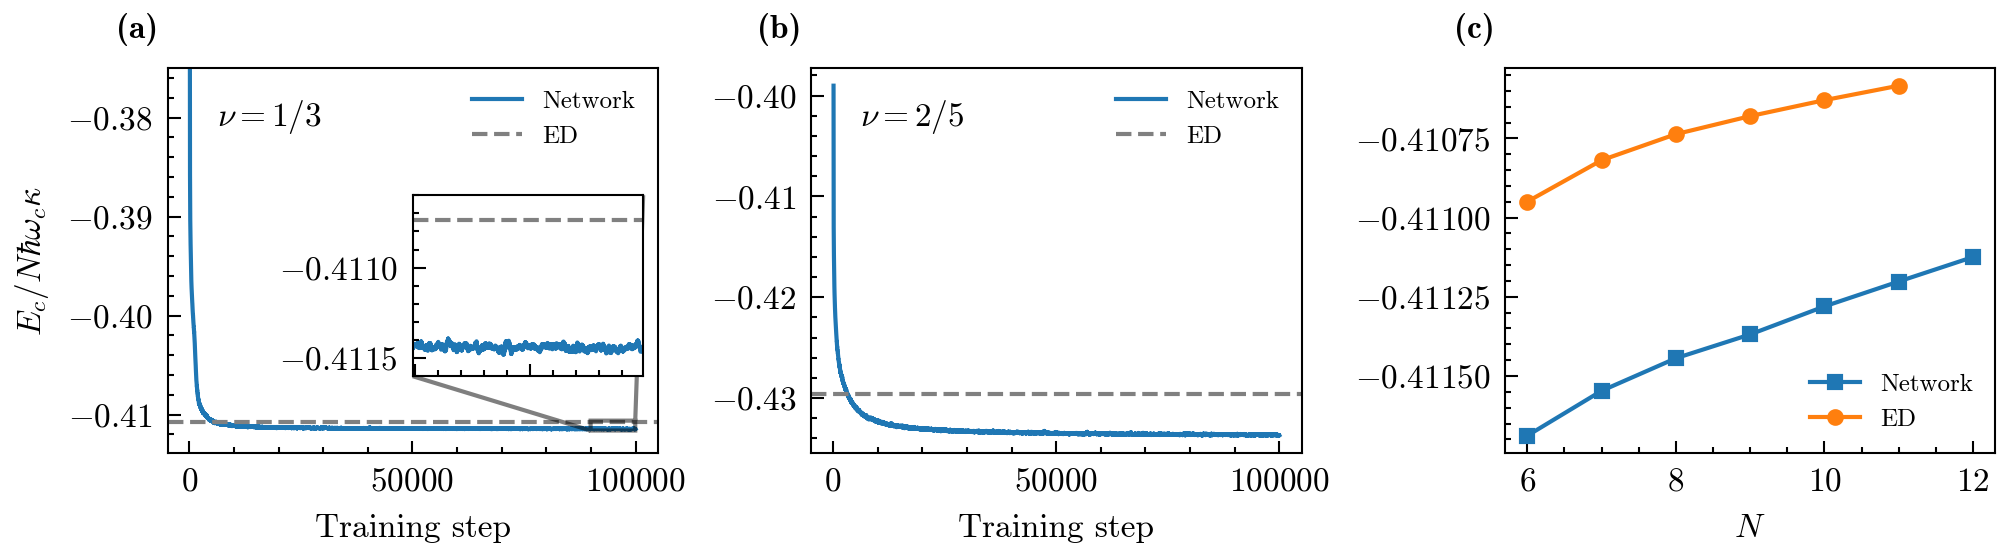

In [ ]:
with acplot("train-and-energy", figsize_cm=(17, 4.7), save="eps") as fig:
    ax1, ax2, ax3 = fig.subplots(1, 3)
    train_curve_1_3(ax1)
    ax1.text(0.1, 0.85, r"$\nu=1/3$", transform=ax1.transAxes)
    train_curve_2_5(ax2)
    ax2.text(0.1, 0.85, r"$\nu=2/5$", transform=ax2.transAxes)
    energy_vs_n(ax3)
    acplot.label_axes(fig.axes, offset=(-0.02, 0.08), use_parentheses=True)

## Figure 3

In [ ]:
def energy_llm(ax):
    axin = ax.inset_axes(
        [0.65, 0.6, 0.3, 0.3],
        xlim=(0.35, 0.65),
        ylim=(-0.4113, -0.4108),
        xticklabels=[],
    )
    for a in (ax, axin):
        # Error bar smaller than marker
        a.plot(llm_df["kappa"], llm_df["energy"], marker="^", ms=3, label="Network")
        a.axhline(
            ed_energy(7.7432698280425, 6, 15 / 2, np.sqrt(15 / 2), nu=1 / 3),
            ls="--",
            color=ED_COLOR,
            label="ED",
        )

    ax.set_xlabel(r"$\kappa$")
    ax.set_ylabel(r"$E_c/N\hbar\omega_c\kappa$")
    indicator = ax.indicate_inset_zoom(axin, edgecolor="0.3", linewidth=0.5)
    for line in indicator.connectors:
        line.set(linewidth=0.5)
    ax.legend(loc="lower left")

In [ ]:
def overlap_llm(ax):
    kappas = [0.5, 1, 3, 10]
    overlaps = []
    elec_counts = []
    for kappa in kappas:
        netobs_ckpt = DATA_PATH / f"n6l15/k{kappa}/overlap/netobs_ckpt_000199.npz"
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            overlaps.append(np.sqrt(npf["digest/overlap"]))
        netobs_ckpt = DATA_PATH / f"n6l15/k{kappa}/1rdm/netobs_ckpt_019999.npz"
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            elec_counts.append(npf["digest/trace"].real / 6)
    axin = ax.inset_axes(
        [0.2, 0.1, 0.3, 0.3],
        xlim=(0.35, 1.15),
        ylim=(0.99, 1.002),
        xticklabels=[],
    )
    for a in ax, axin:
        # Error bar smaller than marker
        a.axhline(1, ls=":", color="0.7")
        a.plot(kappas, overlaps, marker="v", ms=3, label=r"$|S|$")
        a.plot(kappas, elec_counts, marker="s", ms=3, label=r"$N_\text{LLL}/N$")

    ax.set_xlabel(r"$\kappa$")
    indicator = ax.indicate_inset_zoom(axin, edgecolor="0.3", linewidth=0.5)
    for line in indicator.connectors:
        line.set(linewidth=0.5)
    ax.legend()

In [ ]:
def pcf_llm(ax):
    ax.axhline(1, ls=":", color="0.7")

    netobs_ckpt = DATA_PATH / "n6l15/cf/pair_corr/netobs_ckpt_099999.npz"
    with netobs_ckpt.open("rb") as f, np.load(f) as npf:
        steps = 1e5
        pcf = npf["state/pair_corr"] / steps
    theta = np.linspace(0, np.pi, len(pcf)) + np.pi / len(pcf) / 2
    ax.plot(theta[1:-1], pcf[1:-1], label="Laughlin", color="C6")

    kappas = [0.5, 1, 3, 10]
    for kappa in kappas:
        netobs_ckpt = DATA_PATH / f"n6l15/k{kappa}/pair_corr/netobs_ckpt_009999.npz"
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            steps = 52097 if kappa == 1 else 1e4
            pcf = npf["state/pair_corr"] / steps
        theta = np.linspace(0, np.pi, len(pcf)) + np.pi / len(pcf) / 2
        ax.plot(theta[1:-1], pcf[1:-1], label=rf"$\kappa={kappa}$")

    ax.set_ylim(0, 2)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$g(\theta)$")
    ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


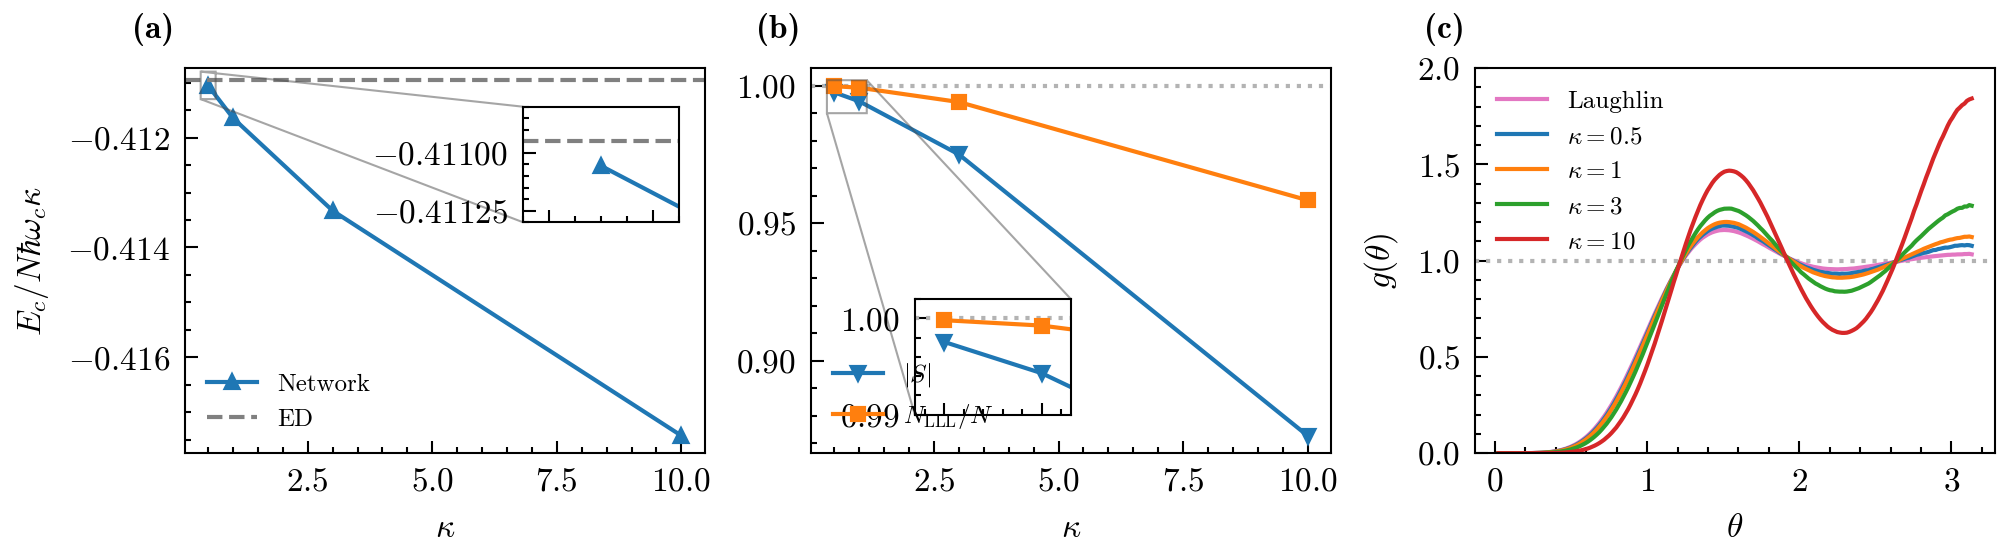

In [ ]:
with acplot("ground-llm", figsize_cm=(17, 4.7), save="eps") as fig:
    ax1, ax2, ax3 = fig.subplots(1, 3)
    energy_llm(ax1)
    overlap_llm(ax2)
    pcf_llm(ax3)
    acplot.label_axes(fig.axes, offset=(-0.02, 0.08), use_parentheses=True)

## Figure 4

In [ ]:
def charge_gap_llm(ax):
    ax.plot(llm_df["kappa"], llm_df["gap"], marker="^", ms=3, label="Network")
    ax.axhline(
        6
        * (
            ed_energy(7.5232159099929, 6, 16 / 2, np.sqrt(16 / 2), q=1 / 3, nu=1 / 3)
            + ed_energy(8.1668930009276, 6, 14 / 2, np.sqrt(14 / 2), q=1 / 3, nu=1 / 3)
            - 2 * ed_energy(7.7432698280425, 6, 15 / 2, np.sqrt(15 / 2), nu=1 / 3)
        ),
        ls="--",
        color=ED_COLOR,
        label="ED",
    )
    ax.set_xlabel(r"$\kappa$")
    ax.set_ylabel(r"$E_c^\text{gap}/\hbar\omega_c\kappa$")
    ax.legend()

In [ ]:
ed_theta = np.linspace(1e-6, np.pi, 101)

In [ ]:
# fmt: off
qh_ed_density = np.array([
    0.00701951,0.00839663,0.0125113,0.0193139,0.0287225,0.0406241,0.054877,0.0713122,0.0897367,
    0.109937,0.13168,0.15472,0.178801,0.20366,0.22903,0.254648,0.280253,0.305595,0.330434,
    0.354546,0.377726,0.399786,0.420565,0.43992,0.457738,0.473929,0.488429,0.501202,0.512234,
    0.521536,0.529144,0.535113,0.539517,0.542449,0.544015,0.544335,0.543536,0.541756,0.539135,
    0.535816,0.531941,0.527652,0.523083,0.518364,0.513617,0.508952,0.504471,0.500264,0.496406,
    0.492963,0.489985,0.487509,0.485562,0.484157,0.483294,0.482964,0.483148,0.483815,0.48493,
    0.486449,0.488322,0.490496,0.492914,0.495516,0.498243,0.501034,0.503831,0.506578,0.509221,
    0.51171,0.514,0.516052,0.51783,0.519306,0.520458,0.521271,0.521734,0.521844,0.521606,0.521029,
    0.520127,0.518922,0.517439,0.515709,0.513765,0.511645,0.509389,0.507038,0.504636,0.502226,
    0.499851,0.497554,0.495376,0.493354,0.491524,0.489918,0.488565,0.487487,0.486703,0.486228,0.486068
])
# fmt: on

In [ ]:
# fmt: off
qp_ed_density = np.array([
    0.524136,0.524734,0.526516,0.529442,0.533449,0.538451,0.544337,0.55098,0.558235,0.565942,
    0.573932,0.582028,0.590049,0.597817,0.605153,0.61189,0.617867,0.62294,0.62698,0.629876,
    0.631539,0.6319,0.630916,0.628565,0.62485,0.619798,0.613458,0.605899,0.597213,0.587505,
    0.5769,0.565533,0.553549,0.541104,0.528353,0.515458,0.502575,0.489861,0.477462,0.465519,
    0.45416,0.443501,0.433646,0.424681,0.416677,0.409689,0.403756,0.398897,0.395119,0.392411,
    0.390746,0.390087,0.39038,0.391562,0.393562,0.396297,0.399682,0.403623,0.408024,0.412788,
    0.417817,0.423014,0.428285,0.433538,0.438688,0.443652,0.448358,0.452737,0.45673,0.460286,
    0.46336,0.465919,0.467937,0.469396,0.470289,0.470616,0.470383,0.469609,0.468315,0.466533,
    0.464298,0.461654,0.458648,0.455331,0.451759,0.44799,0.444084,0.440104,0.43611,0.432165,
    0.428328,0.424658,0.42121,0.418036,0.415182,0.412692,0.410603,0.408945,0.407742,0.407014,0.40677
])
# fmt: on

In [ ]:
def weighted_density_qp1(ax):
    netobs_ckpts = {
        "Laughlin": DATA_PATH / "n6l14/cf/lz3/density/netobs_ckpt_099999.npz",
        r"$\kappa=0.5$": DATA_PATH / "n6l14/k0.5/lz3/density/netobs_ckpt_099999.npz",
        r"$\kappa=1$": DATA_PATH / "n6l14/k1/lz3/density/netobs_ckpt_099999.npz",
        r"$\kappa=3$": DATA_PATH / "n6l14/k3/lz3/density/netobs_ckpt_099999.npz",
        r"$\kappa=10$": DATA_PATH / "n6l14/k10/lz3/density/netobs_ckpt_099999.npz",
    }
    ax.axhline(1.5 / np.pi, ls=":", color="0.7", label="Uniform")
    ax.plot(ed_theta, qp_ed_density, color=ED_COLOR, label="ED")
    for name, netobs_ckpt in netobs_ckpts.items():
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            steps = npf["i"] + 1
            # 1000 / pi is delta function approx, 1 / 2pi is phi integral
            density = npf["state/map"] / steps / 3360 * 1000 / 2 / np.pi**2
        xx = np.linspace(0, np.pi, len(density), False) + np.pi / len(density) / 2
        color = "C6" if name == "Laughlin" else None
        ax.plot(xx[6:-6], (density / np.sin(xx))[6:-6], label=name, color=color)

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$R^2 \rho$")
    ax.set_ylim(0.18, None)

    h, l = ax.get_legend_handles_labels()
    ax.legend(h[3:] + h[:3], l[3:] + l[:3], ncols=2)

In [ ]:
def weighted_density_qh1(ax):
    netobs_ckpts = {
        "Laughlin": DATA_PATH / "n6l16/cf/lz-3/density/netobs_ckpt_099999.npz",
        r"$\kappa=0.5$": DATA_PATH / "n6l16/k0.5/lz-3/density/netobs_ckpt_099999.npz",
        r"$\kappa=1$": DATA_PATH / "n6l16/k1/lz-3/density/netobs_ckpt_099999.npz",
        r"$\kappa=3$": DATA_PATH / "n6l16/k3/lz-3/density/netobs_ckpt_099999.npz",
        r"$\kappa=10$": DATA_PATH / "n6l16/k10/lz-3/density/netobs_ckpt_099999.npz",
    }
    ax.axhline(1.5 / np.pi, ls=":", color="0.7", label="Uniform")
    ax.plot(ed_theta, qh_ed_density, color=ED_COLOR, label="ED")
    for name, netobs_ckpt in netobs_ckpts.items():
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            steps = npf["i"] + 1
            # 1000 / pi is delta function approx, 1 / 2pi is phi integral
            density = npf["state/map"] / steps / 3360 * 1000 / 2 / np.pi**2
        xx = np.linspace(0, np.pi, len(density), False) + np.pi / len(density) / 2
        color = "C6" if name == "Laughlin" else None
        ax.plot(xx[6:-6], (density / np.sin(xx))[6:-6], label=name, color=color)

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$R^2 \rho$")

    h, l = ax.get_legend_handles_labels()
    ax.legend(h[3:] + h[:3], l[3:] + l[:3], ncols=2)

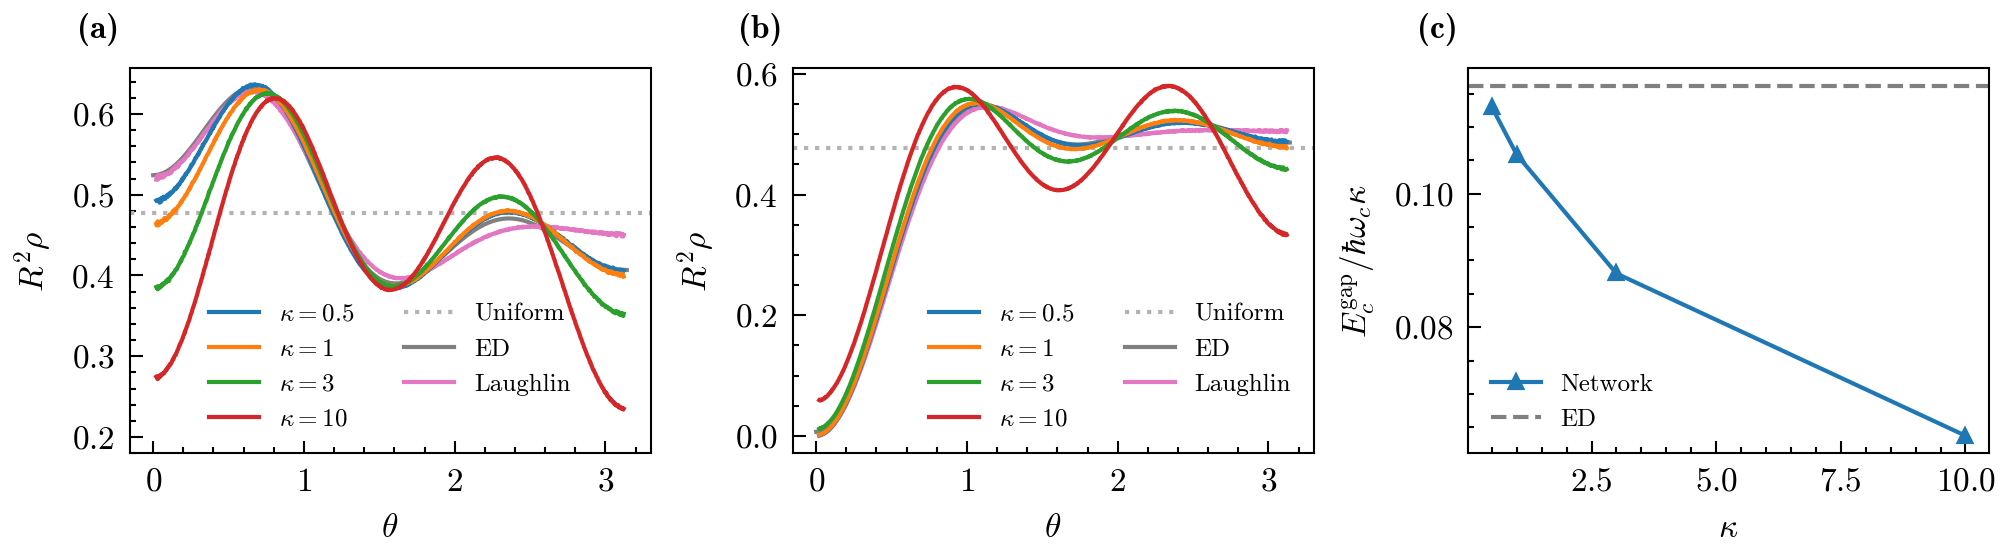

In [ ]:
with acplot("excite-llm", figsize_cm=(17, 4.7), save="eps") as fig:
    ax1, ax2, ax3 = fig.subplots(1, 3)
    weighted_density_qp1(ax1)
    weighted_density_qh1(ax2)
    charge_gap_llm(ax3)
    acplot.label_axes(fig.axes, offset=(-0.02, 0.08), use_parentheses=True)

## Figure S1

In [ ]:
def outliers(ax, csvf):
    df = pd.read_csv(csvf)
    energy = correct_energy(
        df["kinetic"], df["potential"], 8, 21 / 2, np.sqrt(21 / 2), 1 / 3
    )
    mask = energy.abs() > 10 * energy.abs().median()
    index = np.median(np.reshape(df["step"], (-1, 5000)), axis=-1)
    counts = np.sum(np.reshape(mask, (-1, 5000)), axis=-1)
    ax.bar(index, counts, ec="k", width=5000)
    ax.set_xlabel("Steps")

In [ ]:
def outliers_vs_n(ax):
    available_n = np.arange(6, 13)
    counts = []
    for n in available_n:
        flux = 3 * n - 3
        df = pd.read_csv(DATA_PATH / f"n{n}l{flux}/k1/train_stats.csv")
        energy = correct_energy(
            df["kinetic"], df["potential"], n, flux / 2, np.sqrt(flux / 2), 1 / 3
        )[-50000:]
        counts.append(np.sum(energy.abs() > 10 * energy.abs().median()) / 10)
    ax.plot(available_n, counts, marker="o")
    ax.set_xlabel("$N$")

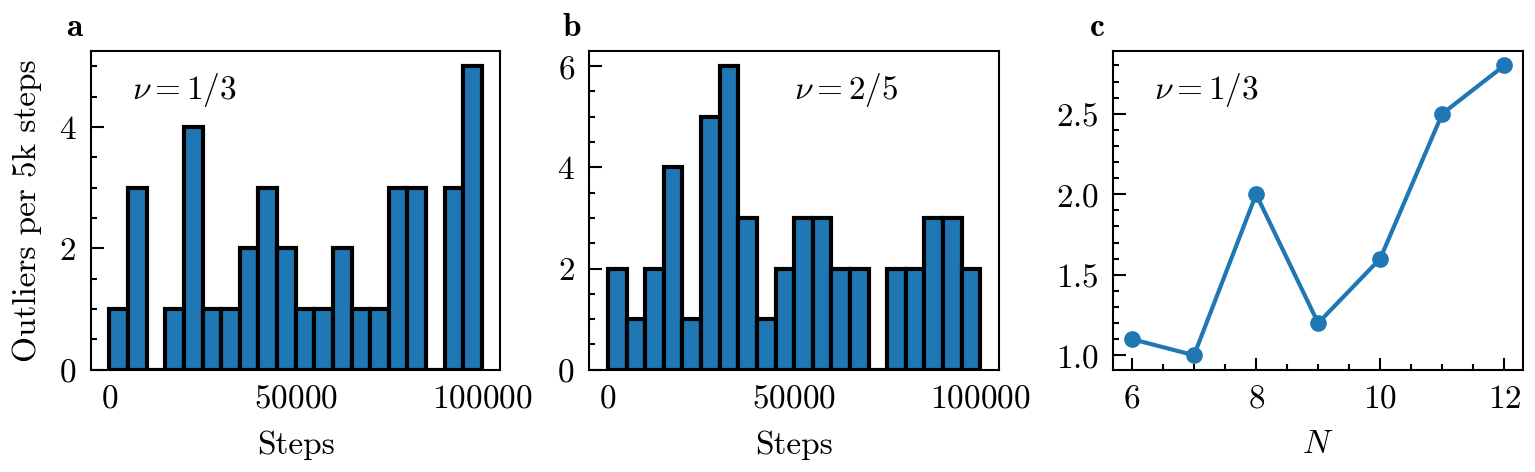

In [ ]:
with acplot("outliers", figsize_cm=(13, 4), save="eps") as fig:
    ax1, ax2, ax3 = fig.subplots(1, 3)
    outliers(ax1, DATA_PATH / "n8l21/k1/train_stats.csv")
    outliers(ax2, DATA_PATH / "n8l16/k1/train_stats.csv")
    outliers_vs_n(ax3)
    ax1.text(0.1, 0.85, r"$\nu=1/3$", transform=ax1.transAxes)
    ax2.text(0.5, 0.85, r"$\nu=2/5$", transform=ax2.transAxes)
    ax3.text(0.1, 0.85, r"$\nu=1/3$", transform=ax3.transAxes)
    ax1.set_ylabel("Outliers per 5k steps")
    acplot.label_axes(fig.axes)

## Figure S2

In [ ]:
def plot_density(ax, netobs_ckpts):
    ax.axhline(1.5 / np.pi, ls=":", color="0.7", label="Uniform")
    for name, netobs_ckpt in netobs_ckpts.items():
        with netobs_ckpt.open("rb") as f, np.load(f) as npf:
            steps = npf["i"] + 1
            # 1000 / pi is delta function approx, 1 / 2pi is phi integral
            density = npf["state/map"] / steps / 3360 * 1000 / 2 / np.pi**2
        xx = np.linspace(0, np.pi, len(density), False) + np.pi / len(density) / 2
        color = "C6" if name == "Laughlin" else None
        ax.plot(xx[6:-6], (density / np.sin(xx))[6:-6], label=name, color=color)

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$R^2 \rho$")
    ax.set_ylim(0, None)

    ax.legend(loc="lower center")

In [ ]:
def weighted_density_qp(ax):
    plot_density(
        ax,
        {
            r"$\kappa=1$": DATA_PATH / "n6l14/k1/lz0/density/netobs_ckpt_099999.npz",
            "Laughlin": DATA_PATH / "n6l14/cf/lz0/density/netobs_ckpt_099999.npz",
        },
    )

In [ ]:
def weighted_density_qh(ax):
    plot_density(
        ax,
        {
            r"$\kappa=1$": DATA_PATH / "n6l16/k1/lz0/density/netobs_ckpt_099999.npz",
            "Laughlin": DATA_PATH / "n6l16/cf/lz0/density/netobs_ckpt_099999.npz",
        },
    )

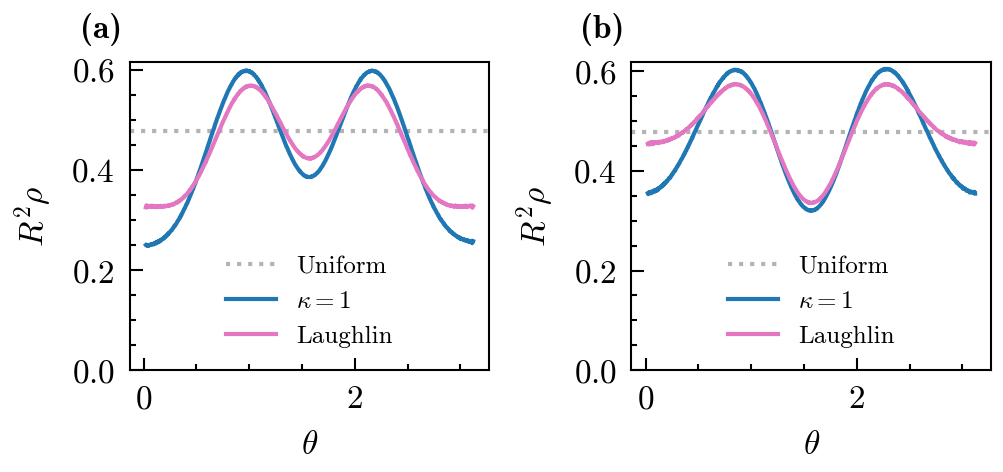

In [ ]:
with acplot("equator-density", figsize_cm=(8.5, 4), save="eps") as fig:
    ax1, ax2 = fig.subplots(1, 2)
    weighted_density_qp(ax1)
    weighted_density_qh(ax2)
    acplot.label_axes(fig.axes, offset=(-0.02, 0.08), use_parentheses=True)